# Estimation of Navier-Stokes equation
## Done by: Andreea-Ioana Florea

In [1]:
print("Hello, world!!!")

Hello, world!!!


In [2]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
# Physical parameters
rho = 1  # Density
mu = 0.01   # Viscosity
u_in = 1
D = 1
L = 2

# Define geometry: A rectangle
#geom = dde.geometry.Rectangle(xmin=[-L / 2, -D / 2], xmax=[L / 2, D / 2])
# ... [Keep your Physical parameters setup: rho, mu, u_in, etc.] ...

# --- NEW GEOMETRY SETUP ---

# 1. Main Channel
channel = dde.geometry.Rectangle(xmin=[-L / 2, -D / 2], xmax=[L / 2, D / 2])

# 2. Define the Barrier (The constrictions)
# Position the barrier slightly to the left (like point 1 in your image)
barrier_x_start = -0.6
barrier_x_end = -0.4  # The barrier is 0.2 units thick
gap_height = 0.3      # The size of the hole in the middle

# Top Block of the barrier
barrier_top = dde.geometry.Rectangle(
    xmin=[barrier_x_start, gap_height/2],
    xmax=[barrier_x_end, D/2]
)

# Bottom Block of the barrier
barrier_bottom = dde.geometry.Rectangle(
    xmin=[barrier_x_start, -D/2],
    xmax=[barrier_x_end, -gap_height/2]
)

# 3. Combine: Channel MINUS the barriers
geom_space = channel - barrier_top - barrier_bottom

# 4. Time Domain
geom_time = dde.geometry.TimeDomain(0, 5)
geom = dde.geometry.GeometryXTime(geom_space, geom_time)

In [4]:
def boundary_wall(X, on_boundary):
    # Top and Bottom walls of the main channel
    on_wall = np.logical_and(
        np.logical_or(
            np.isclose(X[1], -D / 2, rtol=1e-05, atol=1e-08),
            np.isclose(X[1], D / 2, rtol=1e-05, atol=1e-08),
        ),
        on_boundary,
    )
    return on_wall

def boundary_inlet(X, on_boundary):
    # Left wall
    return np.logical_and(np.isclose(X[0], -L / 2, rtol=1e-5, atol=1e-8), on_boundary)

def boundary_outlet(X, on_boundary):
    # Right wall
    return np.logical_and(np.isclose(X[0], L / 2, rtol=1e-5, atol=1e-8), on_boundary)

def boundary_obstacles(X, on_boundary):
    # Detects the internal barrier walls
    # 1. Check if we are on the outer box (Inlet/Outlet/Top/Bottom main walls)
    on_left = np.isclose(X[0], -L/2)
    on_right = np.isclose(X[0], L/2)
    on_bottom = np.isclose(X[1], -D/2)
    on_top = np.isclose(X[1], D/2)

    on_outer_box = on_left | on_right | on_bottom | on_top

    # 2. If it is on a boundary, but NOT the outer box, it is the Barrier
    return on_boundary and not on_outer_box

# BC Objects
# No-slip for barrier walls
bc_obs_u = dde.DirichletBC(geom, lambda X: 0.0, boundary_obstacles, component=0)
bc_obs_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_obstacles, component=1)

# Outer walls
bc_wall_u = dde.DirichletBC(geom, lambda X: 0.0, boundary_wall, component=0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_wall, component=1)

# Inlet
bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component=0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_inlet, component=1)

# Outlet
bc_outlet_p = dde.DirichletBC(geom, lambda X: 0.0, boundary_outlet, component=2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_outlet, component=1)

In [5]:
# Define PDE system (Standard Navier-Stokes)
def pde(X, Y):
    # X = [x, y, t], Y = [u, v, p]
    du_t = dde.grad.jacobian(Y, X, i=0, j=2)
    dv_t = dde.grad.jacobian(Y, X, i=1, j=2)

    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)

    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    pde_u = du_t + Y[:, 0:1] * du_x + Y[:, 1:2] * du_y + 1 / rho * dp_x - (mu / rho) * (du_xx + du_yy)
    pde_v = dv_t + Y[:, 0:1] * dv_x + Y[:, 1:2] * dv_y + 1 / rho * dp_y - (mu / rho) * (dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]

ic_u = dde.IC(geom, lambda X: 0.0, lambda _, on_initial: on_initial, component=0)
ic_v = dde.IC(geom, lambda X: 0.0, lambda _, on_initial: on_initial, component=1)


In [6]:
# Use TimePDE for time-dependent (transient) simulations
data = dde.data.TimePDE(
    geom,
    pde,
    [
        # --- Spatial Boundaries ---
        bc_wall_u, bc_wall_v,      # Walls (No slip)
        bc_inlet_u, bc_inlet_v,    # Left Inlet (Flow enters here)
        bc_outlet_p, bc_outlet_v,  # Right Outlet (Flow exits here)
        bc_obs_u, bc_obs_v,        # Obstacles (Heart & Cylinder)

        # --- Initial Conditions (t=0) ---
        ic_u, ic_v                 # State of fluid at start
    ],
    num_domain=5000,    # Points inside the channel
    num_boundary=1000,  # Points on walls/inlet/outlet
    num_initial=1000    # Points at time t=0
)

In [7]:
# Define neural network
net = dde.maps.FNN([3] + [64] * 5 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

In [8]:
# Compile and train
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=5000)

Compiling model...
'compile' took 0.068808 s

Training model...

Cause: could not parse the source code of <function <lambda> at 0x0000013586BBDF30>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000013586BBDF30>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @

Generating animation for Barrier Flow...


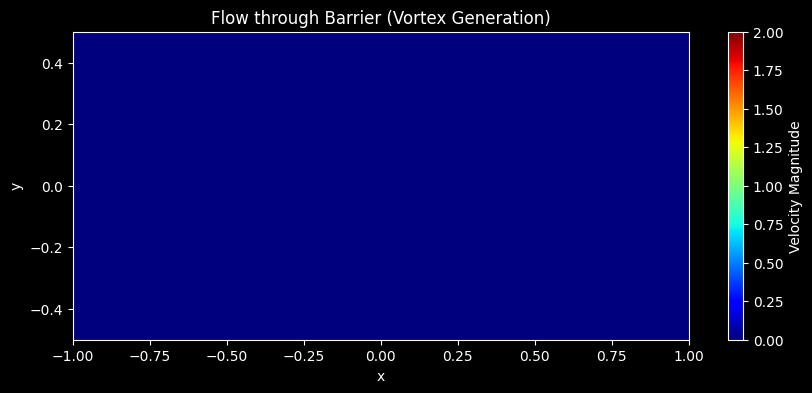

In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

print("Generating animation for Barrier Flow...")

# 1. Setup Grid
grid_x, grid_y = np.meshgrid(
    np.linspace(-L/2, L/2, 400),
    np.linspace(-D/2, D/2, 200)
)

# 2. Define Masks for the Barrier
# Must match the coordinates in Cell 1
b_x_start, b_x_end = -0.6, -0.4
b_gap = 0.2 / 2  # Half of the gap height

# Mask Top Block
mask_top = (grid_x >= b_x_start) & (grid_x <= b_x_end) & (grid_y >= b_gap)
# Mask Bottom Block
mask_bottom = (grid_x >= b_x_start) & (grid_x <= b_x_end) & (grid_y <= -b_gap)

mask_total = mask_top | mask_bottom

# 3. Setup Figure
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("Flow through Barrier (Vortex Generation)")

# Placeholder plot
cax = ax.imshow(np.zeros_like(grid_x),
                extent=(-L/2, L/2, -D/2, D/2),
                origin='lower',
                cmap='jet',
                vmin=0, vmax=2.0, # Higher max speed because of the jet effect
                interpolation='bilinear')
fig.colorbar(cax, ax=ax, label='Velocity Magnitude')

# 4. Animation Function
def update(frame):
    current_t = frame * 0.05

    t_column = np.full((grid_x.size, 1), current_t)
    X_predict = np.column_stack([grid_x.flatten(), grid_y.flatten(), t_column])

    result = model.predict(X_predict)
    u = result[:, 0].reshape(grid_x.shape)
    v = result[:, 1].reshape(grid_x.shape)
    speed = np.sqrt(u**2 + v**2)

    # Hide the barrier
    speed[mask_total] = np.nan

    cax.set_data(speed)
    ax.set_title(f"Time: {current_t:.2f}s")
    return cax,

ani = FuncAnimation(fig, update, frames=100, interval=50, blit=False)
plt.show()

Setting up Robust Particle Simulation...


C:\Users\andre\.conda\envs\challenge_Navier_Stokes_ResNet\lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


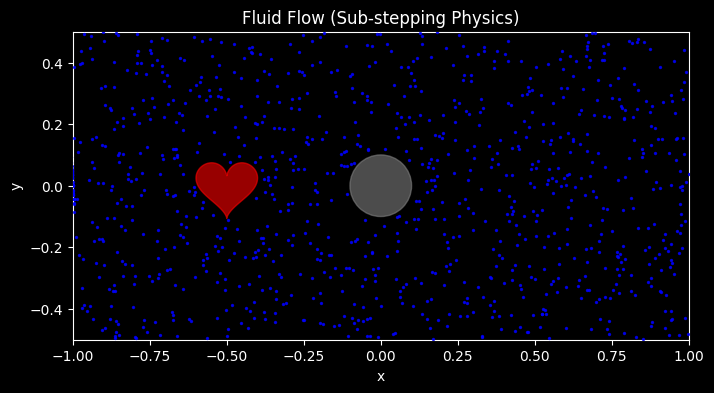

In [10]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from matplotlib.path import Path

print("Setting up Robust Particle Simulation...")


# --- 1. Define "Kill Zones" (Collision Logic) ---
# We define zones slightly larger than the visual shapes.
# If a particle touches these, it is reset immediately.

def check_cylinder_hit(x, y):
    # Visual radius 0.1, Collision radius 0.11
    return (x ** 2 + y ** 2) < 0.11 ** 2


# Heart Shape Logic
t_plot = np.linspace(0, 2 * np.pi, 200)
# Visual Heart (for drawing)
h_vis_x = 0.1 * (16 * np.sin(t_plot) ** 3) / 16 - 0.5
h_vis_y = 0.1 * (13 * np.cos(t_plot) - 5 * np.cos(2 * t_plot) - 2 * np.cos(3 * t_plot) - np.cos(4 * t_plot)) / 16

# Collision Heart (Slightly larger buffer)
h_col_x = 0.11 * (16 * np.sin(t_plot) ** 3) / 16 - 0.5
h_col_y = 0.11 * (13 * np.cos(t_plot) - 5 * np.cos(2 * t_plot) - 2 * np.cos(3 * t_plot) - np.cos(4 * t_plot)) / 16
heart_collision_path = Path(np.vstack([h_col_x, h_col_y]).T)


def check_heart_hit(x, y):
    # Bounding box check first
    potential_hit = (x > -0.7) & (x < -0.3)
    result = np.zeros_like(x, dtype=bool)
    if np.any(potential_hit):
        pts = np.column_stack([x[potential_hit], y[potential_hit]])
        result[potential_hit] = heart_collision_path.contains_points(pts)
    return result


# --- 2. Initialize Particles ---
num_particles = 1000
p_x = np.random.uniform(-L / 2, L / 2, num_particles)
p_y = np.random.uniform(-D / 2, D / 2, num_particles)

# Clear initial bad spawns
bad = check_cylinder_hit(p_x, p_y) | check_heart_hit(p_x, p_y)
p_x[bad] = -L / 2

# --- 3. Setup Plot ---
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlim(-L / 2, L / 2)
ax.set_ylim(-D / 2, D / 2)
ax.set_aspect('equal')
ax.set_title("Fluid Flow (Sub-stepping Physics)")
ax.set_xlabel("x")
ax.set_ylabel("y")

# Draw VISUAL Obstacles
circle = plt.Circle((0, 0), 0.1, color='gray', alpha=0.6, zorder=5)
ax.add_patch(circle)
patch_heart = plt.Polygon(np.vstack([h_vis_x, h_vis_y]).T, color='red', alpha=0.6, zorder=5)
ax.add_patch(patch_heart)

particles_plot = ax.scatter(p_x, p_y, s=2, c='blue', alpha=0.8, zorder=10)


# --- 4. Sub-stepping Update Loop ---
def update(frame):
    global p_x, p_y

    # We define how much time passes in one video frame
    total_dt_per_frame = 0.05
    # We split this into 5 small "physics steps" to catch collisions
    steps = 5
    dt = total_dt_per_frame / steps

    current_t = frame * total_dt_per_frame

    # SUB-STEPPING LOOP
    for _ in range(steps):
        # 1. Predict Velocity at current spot
        # (Note: In a real PDE solver we might update T inside this loop,
        # but for visualization, using frame time is fine)
        t_stack = np.full((num_particles, 1), current_t)
        X_in = np.column_stack([p_x, p_y, t_stack])

        vel = model.predict(X_in)
        u = vel[:, 0]
        v = vel[:, 1]

        # 2. Move particles by a TINY amount
        p_x += u * dt
        p_y += v * dt

        # 3. Check for Collisions IMMEDIATELY
        hit_cyl = check_cylinder_hit(p_x, p_y)
        hit_hrt = check_heart_hit(p_x, p_y)
        hit_out = p_x > L / 2
        hit_wall = (p_y > D / 2) | (p_y < -D / 2)

        mask_reset = hit_cyl | hit_hrt | hit_out | hit_wall

        # 4. Reset crashed particles immediately so they don't go deeper
        if np.any(mask_reset):
            n = np.sum(mask_reset)
            p_x[mask_reset] = -L / 2 + np.random.uniform(0, 0.05, n)
            p_y[mask_reset] = np.random.uniform(-D / 2, D / 2, n)

    # Update plot after the 5 small steps are done
    particles_plot.set_offsets(np.c_[p_x, p_y])
    return particles_plot,


ani = FuncAnimation(fig, update, frames=1000, interval=30, blit=True)
plt.show()

Generating animation for Barrier Flow...
Video saved successfully!


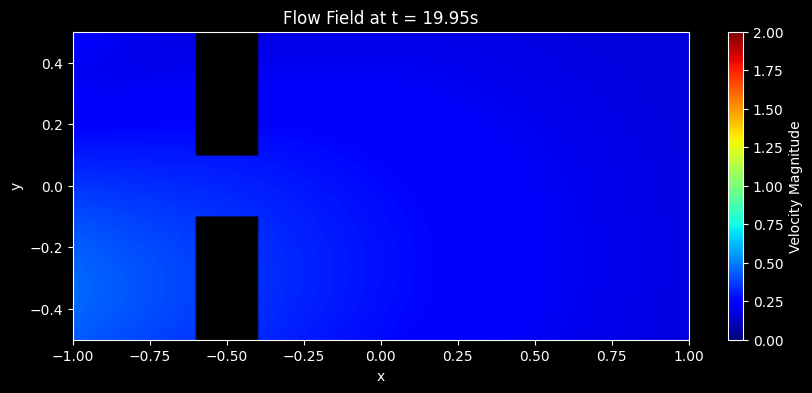

In [18]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np

print("Generating animation for Barrier Flow...")

# 1. Create the Regular Grid for Plotting
# We create a new grid here to ensure clean shapes
grid_x, grid_y = np.meshgrid(
    np.linspace(-L/2, L/2, 300),
    np.linspace(-D/2, D/2, 150)
)

# 2. Define the Barrier Masks (MUST match the geometry in Cell 1)
# Barrier coordinates
b_x_start, b_x_end = -0.6, -0.4
b_gap = 0.2 / 2  # Half of the gap height (gap is 0.2)

# Create boolean masks for the barriers
mask_top = (grid_x >= b_x_start) & (grid_x <= b_x_end) & (grid_y >= b_gap)
mask_bottom = (grid_x >= b_x_start) & (grid_x <= b_x_end) & (grid_y <= -b_gap)

# Combine them into one mask
mask_total = mask_top | mask_bottom

# 3. Setup the Figure
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("Transient Flow with Barrier (Vortex Generation)")

# Initialize the plot
cax = ax.imshow(np.zeros_like(grid_x),
                extent=(-L/2, L/2, -D/2, D/2),
                origin='lower',
                cmap='jet',
                vmin=0, vmax=2.0, # Adjusted scale for jet flow
                interpolation='bilinear')
fig.colorbar(cax, ax=ax, label='Velocity Magnitude')

# 4. The Animation Update Function
def update(frame):
    # Calculate current time (advancing 0.05s per frame)
    current_t = frame * 0.05

    # Create input coordinates for the whole grid
    t_column = np.full((grid_x.size, 1), current_t)
    X_predict = np.column_stack([grid_x.flatten(), grid_y.flatten(), t_column])

    # Predict velocity
    result = model.predict(X_predict)
    u = result[:, 0].reshape(grid_x.shape)
    v = result[:, 1].reshape(grid_x.shape)
    speed = np.sqrt(u**2 + v**2)

    # Apply the mask (Nan makes it white/transparent)
    speed[mask_total] = np.nan

    # Update the image
    cax.set_data(speed)
    ax.set_title(f"Flow Field at t = {current_t:.2f}s")
    return cax,

# 5. Run and Save
ani = FuncAnimation(fig, update, frames=400, interval=50, blit=False)

try:
    writer = FFMpegWriter(fps=20)
    ani.save("flow_field_barrier.mp4", writer=writer, dpi=200)
    print("Video saved successfully!")
except Exception as e:
    print(f"Could not save video (displaying instead): {e}")

plt.show()

In [16]:
def update(frame):
    ax.clear()
    # Create a time array for the current frame
    t_step = frame * 0.1
    t_array = np.full((grid_x.ravel().shape[0], 1), t_step)

    # Combine grid points with current time: [x, y, t]
    X_test = np.column_stack([grid_x.ravel(), grid_y.ravel(), t_array])

    # Predict for this specific time
    res = model.predict(X_test)
    u_frame = res[:, 0].reshape(grid_x.shape)
    v_frame = res[:, 1].reshape(grid_x.shape)
    speed_frame = np.sqrt(u_frame**2 + v_frame**2)

    # Apply masks and plot
    speed_frame[mask_total] = np.nan
    cax = ax.imshow(speed_frame, extent=(-L/2, L/2, -D/2, D/2),
                    origin='lower', cmap='jet')

    # Optional: Add streamplot for extra "fluidity"
    # ax.streamplot(grid_x, grid_y, u_frame, v_frame, color='white', alpha=0.3)

    return cax,

Calculating Physics Metrics...
----------------------------------------
Final Physics Metrics (Mean Absolute Error):
1. Mass Conservation Error: 0.112554
   (Ideal = 0.0. High = Liquid appearing/disappearing)
2. X-Momentum Error:        0.065604
3. Y-Momentum Error:        0.038251
----------------------------------------


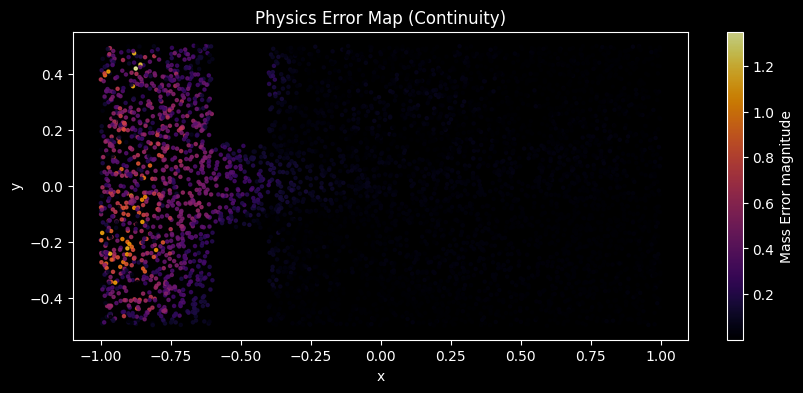

In [17]:
# --- ADVANCED METRICS EVALUATION (CORRECTED) ---
print("Calculating Physics Metrics...")

# 1. Generate a grid of points to test the physics
# We check 5000 random points inside the domain
X_test = geom.random_points(5000)

# 2. Calculate Residuals (Physics Errors)
# We pass 'operator=pde' to tell the model:
# "Don't just give me velocity (u,v), give me the ERROR in the equations."
residuals = model.predict(X_test, operator=pde)

# The output 'residuals' is a list of arrays: [pde_u, pde_v, pde_cont]
# matching the order you returned in your def pde(...) function.
res_u = residuals[0]  # Momentum X error
res_v = residuals[1]  # Momentum Y error
res_cont = residuals[2]  # Continuity error (Mass conservation)

# 3. Compute Mean Errors
mean_res_u = np.mean(np.abs(res_u))
mean_res_v = np.mean(np.abs(res_v))
mean_res_cont = np.mean(np.abs(res_cont))

print("-" * 40)
print(f"Final Physics Metrics (Mean Absolute Error):")
print(f"1. Mass Conservation Error: {mean_res_cont:.6f}")
print(f"   (Ideal = 0.0. High = Liquid appearing/disappearing)")
print(f"2. X-Momentum Error:        {mean_res_u:.6f}")
print(f"3. Y-Momentum Error:        {mean_res_v:.6f}")
print("-" * 40)

# 4. Visualize Where the Physics Fails
# We plot the Mass Conservation Error.
# Bright spots = areas where the liquid is "breaking" physics (usually near walls).
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))
# We use X_test[:, 0] (x-coords) and X_test[:, 1] (y-coords)
sc = ax.scatter(X_test[:, 0], X_test[:, 1], c=np.abs(res_cont), cmap='inferno', s=5, alpha=0.8)
plt.colorbar(sc, label='Mass Error magnitude')
ax.set_title("Physics Error Map (Continuity)")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
plt.show()